# Quick Start

The goal of this notebook is to provide you with a quick overview of some of the key features
of EQcorrscan.  From this you should be able to dig deeper into the API to learn some of the
more advanced features.

## Matched-filter earthquake detection

One of the main applications of EQcorrscan is to detect earthquakes or other seimic signals
using matched-filters (aka template-matching).  To undertake matched-filtering templates are
required.  Templates are simply processed waveforms. In EQcorrscan templates are realised
as `Template` objects, which contain the waveform data and meta-data associated with their
creation. Groups of `Template` objects are stored in `Tribe` objects. To demonstrate this, we
will create a `Tribe` for the Parkfield 2004 earthquake.

Before we begin we will set up logging - EQcorrscan provides textual output through the 
native Python [logging library](https://docs.python.org/3/library/logging.html). The standard
`DEBUG`, `INFO`, `WARNING`, `ERROR` and `CRITICAL` levels are supported.  For this we will
set to `ERROR` to reduce the output.  When starting off you might want to set to `INFO`,
or if something is happening that you don't expect, `DEBUG` will give you much more output.

In [1]:
import logging

logging.basicConfig(
    level=logging.ERROR,
    format="%(asctime)s\t%(name)s\t%(levelname)s\t%(message)s")

First we need a catalog of events. We will just use a few earthquakes from the NCEDC. We are also
only going to used picks from the 20 most picked stations.

/home/calumch/miniconda3/envs/conda_37/lib/python3.7/site-packages/obspy/imaging/maps.py:387: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  width=width, height=height, ax=ax)
/home/calumch/miniconda3/envs/conda_37/lib/python3.7/site-packages/obspy/imaging/maps.py:435: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  bmap.drawcountries(color="0.75")


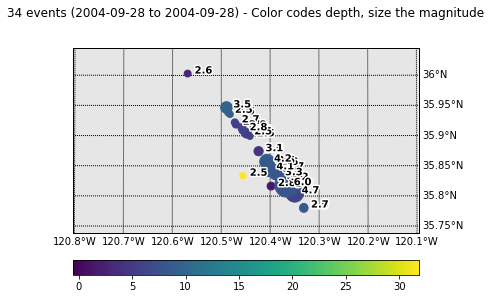

In [2]:
%matplotlib inline
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from eqcorrscan.utils.catalog_utils import filter_picks

client = Client("NCEDC")
t1 = UTCDateTime(2004, 9, 28)
t2 = t1 + 86400
catalog = client.get_events(
    starttime=t1, endtime=t2, minmagnitude=2.5, minlatitude=35.7, maxlatitude=36.1,
    minlongitude=-120.6, maxlongitude=-120.2, includearrivals=True)
fig = catalog.plot(projection="local", resolution="h")
catalog = filter_picks(catalog=catalog, evaluation_mode="manual", top_n_picks=20)

When data are available via a `Client`, you can generate templates directly from the
client without having to download data yourself.  However, if you have data locally
you can pass that data.  Have a look at the notebook on 
[template creation](template_creation.ipynb) for more details on other methods.

In [3]:
from eqcorrscan import Tribe

tribe = Tribe().construct(
    method="from_client", lowcut=4.0, highcut=15.0, samp_rate=50.0, length=6.0,
    filt_order=4, prepick=0.5, client_id=client, catalog=catalog, data_pad=20.,
    process_len=21600, min_snr=5.0, parallel=True)
print(tribe)

Tribe of 34 templates


This makes a tribe by:

1. Downloading data for each event (if multiple events occur close in time they will share data;
2. Detrending, filtering and resampling the data;
3. Trimming the data around picks within each event in the catalog.
    
To make this `Tribe` we used a few different arguments:

- `lowcut`: This controls the lower corner frequency of a filter in Hz.  EQcorrscan
  natively uses Obspy's butterworth filter functions.  For more details, see the 
  [Obspy docs](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.filter.html).
  This can optionally be set to `None` to not apply filtering at low frequencies.
- `highcut`: This controls the upper corner frequency of a filter in Hz. It is applied
  in tandem with lowcut, or can be set to `None` to not apply filtering at high frequencies.
- `samp_rate`: The desired sampling-rate of the templates in Hz.  EQcorrscan requires that
  templates and continuous data be sampled at the same rate.  In this case we are downsampling
  data from 100.0 Hz to 50.0 Hz.  We do this to reduce memory-load. EQcorrscan uses Obspy's
  [resampling method](https://docs.obspy.org/packages/autogen/obspy.core.stream.Stream.resample.html#obspy.core.stream.Stream.resample)
- `length`: This is the length of the template waveform on each channel in seconds.
- `filt_order`: This sets the number of corners/order of the filter applied using
  `highcut` and `lowcut`.
- `prepick`: The number of seconds prior to a phase-pick to start a template waveform.
- `client_id`: This is the `Client` or client ID (e.g. our client id would be `"NCEDC"`)
  from which to download the data from.
- `catalog`: The catalog of events to generate templates for.
- `data_pad`: A fudge-factor to cope with data centres not providing quite the data you asked
  for.  This is the number of seconds extra to download to cope with this.
- `process_len`: The length of data to download in seconds for each template. This should be
  the same as the length of your continuous data, e.g. if you data are in day-long files, this
  should be set to `86400`.
- `min_snr`: The minimum signal-to-noise ratio required for a channel to be included in a
  template.  This provides a simple way of getting rid of poor-quality data from your templates.
- `parallel`: Whether to process the data in parallel or not.  This will increase memory load,
  if you find yourself running out of memory, set `parallel=False` for these template
  construction methods.
      
Lets have a quick look at the attributes of a `Template`:

Template 2004_09_28t17_15_25: 
	 20 channels;
	 lowcut: 4.0 Hz;
	 highcut: 15.0 Hz;
	 sampling rate 50.0 Hz;
	 filter order: 4; 
	 process length: 21600.0 s


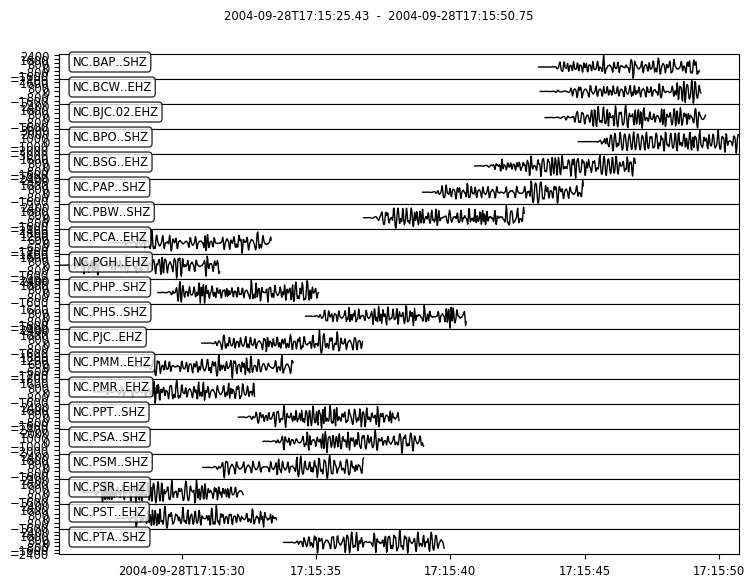

In [4]:
print(tribe[0])
fig = tribe[0].st.plot(equal_scale=False, size=(800, 600))

We can see that this template has data from multiple stations, and that our processing parameters
are stored alongside the template waveform.  This means that we can ensure that when we work
on continuous data to run matched-filtering the data are processed in the same way.

Lets remove templates with fewer than five stations then use this tribe to detect earthquakes 
within the first few days of the Parkfield aftershock sequence:

In [5]:
tribe.templates = [t for t in tribe if len({tr.stats.station for tr in t.st}) >= 5]
print(tribe)
party, st = tribe.client_detect(
    client=client, starttime=t1, endtime=t1 + (86400 * 2), threshold=9., 
    threshold_type="MAD", trig_int=2.0, plot=False, return_stream=True)

Tribe of 28 templates


This will:

1. Download the data required;
2. Process the data in the same way as the templates in the `Tribe` (note that your
   tribe can contain templates processed in different ways: these will be grouped into
   similarly processed templates and the matched-filter process will be run multiple
   times; once for each group of similar templates);
3. Cross-correlate the templates with the processed data and stack the correlations;
4. Detect within each templates stacked cross-correlation array based on a given threshold;
5. Generate `Detection` objects with Obspy events and meta-data
    
Again, we used a few arguments here:

- `client`: This again is the client from which to download data;
- `starttime`: The start of the data we want to detect within;
- `endtime`: The end of the data we want to detect within;
- `threshold`: The threshold for detection: note that the correlation sum is both
  positive and negative valued.  Detections are made based on the absolute of the
  correlation vector, so both postively and negatively correlated detections are made;
- `threshold_type`: The type of threshold to use, in this case we used `"MAD"`, the
  median absolute deviation, our `threshold` is the MAD multiplier;
- `trig_int`: The minimum time (in seconds) between triggers.  The highest absolute
  correlation value will be used within this window if multiple possible triggers
  occur.  Note that this only applies within the detections from one template.
- `plotvar`: We turned plotting off in this case;
- `return_stream`: Setting this to `True` will return the pre-processed stream downloaded
  from the client, allowing us to reuse this stream for later processing.
      
Lets have a look at the cumulative detections we made.

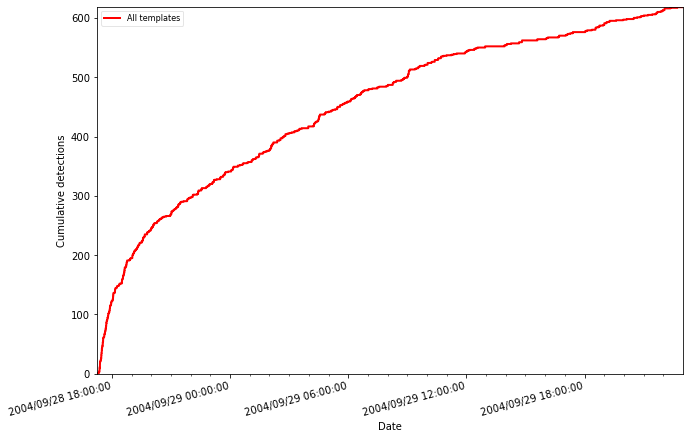

In [6]:
fig = party.plot(plot_grouped=True)

We were returned a `Party` and a `Stream`.  The `Party` is a container for `Family` objects. Each
`Family` contains a `Template` and all the detections associated with that `Template`.  Detections
are stored as `Detection` objects.

Lets have a look at the most productive family:

In [7]:
family = sorted(party.families, key=lambda f: len(f))[-1]
print(family)

Family of 106 detections from template 2004_09_28t20_05_53


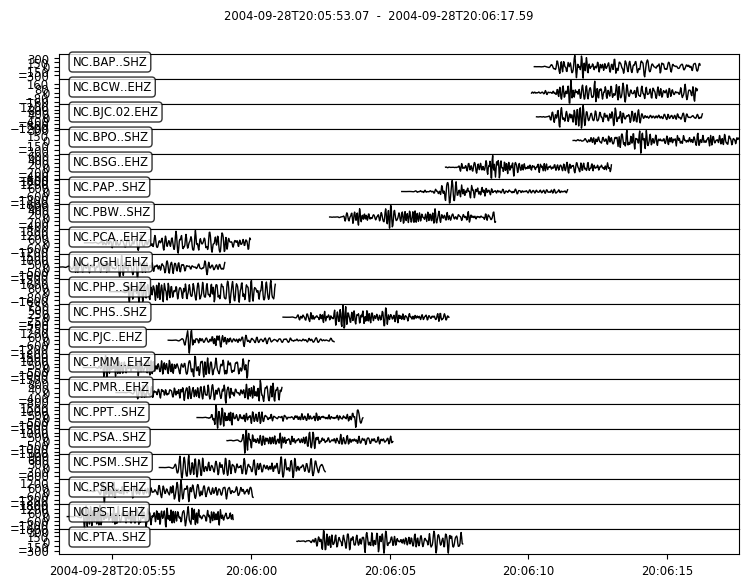

In [8]:
fig = family.template.st.plot(equal_scale=False, size=(800, 600))

We can get a dictionary of streams for each detection in a `Family` and look at some of those:

Detection on template: 2004_09_28t20_05_53 at: 2004-09-28T17:24:03.440000Z with 20 channels: [('BAP', 'SHZ'), ('BCW', 'EHZ'), ('BJC', 'EHZ'), ('BPO', 'SHZ'), ('BSG', 'EHZ'), ('PAP', 'SHZ'), ('PBW', 'SHZ'), ('PCA', 'EHZ'), ('PGH', 'EHZ'), ('PHP', 'SHZ'), ('PHS', 'SHZ'), ('PJC', 'EHZ'), ('PMM', 'EHZ'), ('PMR', 'EHZ'), ('PPT', 'SHZ'), ('PSA', 'SHZ'), ('PSM', 'SHZ'), ('PSR', 'EHZ'), ('PST', 'EHZ'), ('PTA', 'SHZ')]


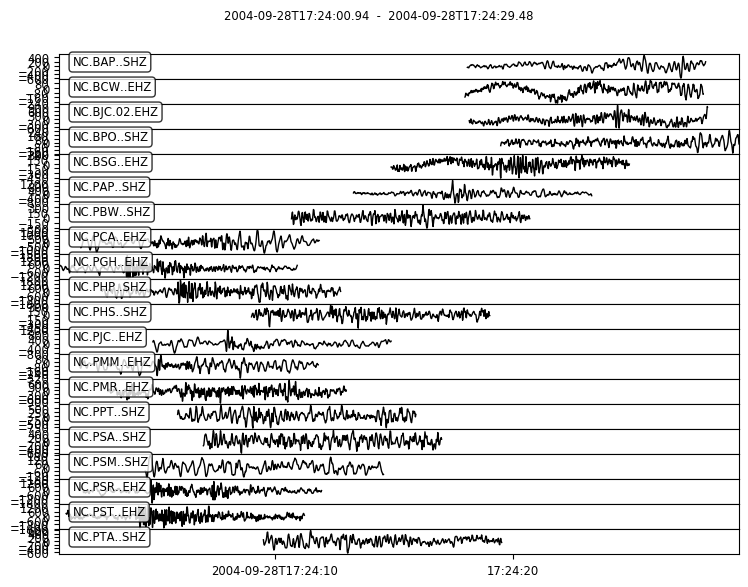

In [9]:
streams = family.extract_streams(stream=st, length=10, prepick=2.5)
print(family.detections[0])
fig = streams[family.detections[0].id].plot(equal_scale=False, size=(800, 600))

On some stations we can clearly see the earthquake that was detected. Remember that these data have not been filtered.

We can also undertake cross-correlation phase-picking using our templates.  This is achieved
using the `lag_calc` method on `Party` or `Family` objects.  You can also use the
`eqcorrscan.core.lag_calc` module directly on other catalogs.

We need to provide a merged stream to the lag-calc function. The stream we have obtained
from `tribe.detect` has overlaps in it. Using `stream.merge()` would result in gaps at those
overlaps, which we do not want. We use `stream.merge(method=1)` to take include the real data
in that gap.

In [10]:
st = st.merge(method=1)
repicked_catalog = party.lag_calc(st, pre_processed=False, shift_len=0.5, min_cc=0.4)

/home/calumch/miniconda3/envs/conda_37/lib/python3.7/site-packages/obspy/signal/detrend.py:35: RuntimeWarning: invalid value encountered in true_divide
  data -= x1 + np.arange(ndat) * (x2 - x1) / float(ndat - 1)


This returns a catalog with picks for each detected event.  The arguments we have used are:

- The stream that we downloaded previously;
- `pre_processed`: Our data have not been processed, so we rely on `lag_calc` to process
  our data - this means that our data will be processed in the same way as our templates were;
- `shift_len`: This is the maximum allowed shift (positive and negative) of the pick-time 
  relative to the template moveout in seconds.
- `min_cc`: The minimum normalised cross-correlation value required to generate a pick. Picks
  are made on the maximum correlation within a window.
  
Lets look at one of the events that we have picked.  The correlation value for the pick is
stored in a comment:

In [20]:
print(repicked_catalog[100].picks[0])

Pick
	     resource_id: ResourceIdentifier(id="smi:local/08139539-1fec-4707-b60e-b87f68ecfb9e")
	            time: UTCDateTime(2004, 9, 28, 18, 45, 22, 820000)
	     waveform_id: WaveformStreamID(network_code='NC', station_code='BPO', channel_code='SHZ', location_code='')
	       method_id: ResourceIdentifier(id="EQcorrscan")
	      phase_hint: 'P'
	 evaluation_mode: 'automatic'
	   creation_info: CreationInfo(agency_id='eqcorrscan.core.lag_calc')
	            ---------
	        comments: 1 Elements


In [21]:
print(repicked_catalog[100].picks[0].comments[0])

Comment(text='cc_max=0.439941', resource_id=ResourceIdentifier(id="smi:local/383b3803-a499-407b-bf1c-8d78ab4b73d1"))


## Note:

Using long templates like this that include both P and S energy does not usually produce good
correlation derived phase arrivals.  This is simply a demonstration.  You should carefully select
your template length, and ideally include both P and S picks in the catalog that you use to
make templates.

Explore the rest of the tutorials and API docs for further hints.
